In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [2]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 150

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 1000 # max 5394

# Number of weak classifiers
nbrWeakClassifiers = 50

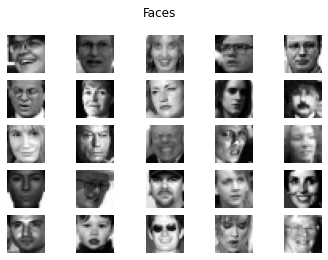

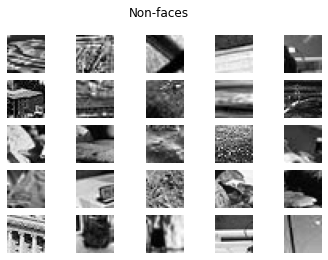

In [3]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

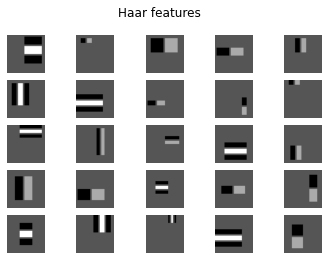

In [4]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(min(nbrHaarFeatures, 25)):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [5]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [6]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py
D = np.ones(len(yTrain))
D /= sum(D)
alpha = np.array([None] * nbrWeakClassifiers)
final_Ps = np.array([None] * nbrWeakClassifiers)
final_Ts = np.array([None] * nbrWeakClassifiers)
final_haar_indices = np.array([None] * nbrWeakClassifiers)

for num_WeakClassifier in range(nbrWeakClassifiers):
    print(f"Weak Classifier number {num_WeakClassifier + 1}")
    minError = np.inf
    for haar_index in range(nbrHaarFeatures):
        T_vals = [min(xTrain[haar_index,:]) - 1] + xTrain[haar_index,:] + [max(xTrain[haar_index,:]) + 1]
        #if haar_index % 50 == 0:
        #    print(f"Haar index number {haar_index}")
        for i in range(len(T_vals) - 1):
            P = 1
            T = (T_vals[i] + T_vals[i + 1]) / 2
            C = WeakClassifier(T, P, xTrain[haar_index, :])
            error = WeakClassifierError(C, D, yTrain)
            if error > 0.5:
                P = -1
                error = 1 - error
            if error < minError:
                best_T = T
                best_P = P
                minError = error
                best_haar_index = haar_index
    alpha[num_WeakClassifier] = np.log((1 - minError) / minError) / 2
    D = D * np.exp(-alpha[num_WeakClassifier] * yTrain * WeakClassifier(best_T, best_P, xTrain[best_haar_index,:]))
    D = D / sum(D)
    final_Ps[num_WeakClassifier] = best_P
    final_Ts[num_WeakClassifier] = best_T
    final_haar_indices[num_WeakClassifier] = best_haar_index

Weak Classifier number 1
Weak Classifier number 2
Weak Classifier number 3
Weak Classifier number 4
Weak Classifier number 5
Weak Classifier number 6
Weak Classifier number 7
Weak Classifier number 8
Weak Classifier number 9
Weak Classifier number 10
Weak Classifier number 11
Weak Classifier number 12
Weak Classifier number 13
Weak Classifier number 14
Weak Classifier number 15
Weak Classifier number 16
Weak Classifier number 17
Weak Classifier number 18
Weak Classifier number 19
Weak Classifier number 20
Weak Classifier number 21
Weak Classifier number 22
Weak Classifier number 23
Weak Classifier number 24
Weak Classifier number 25
Weak Classifier number 26
Weak Classifier number 27
Weak Classifier number 28
Weak Classifier number 29
Weak Classifier number 30
Weak Classifier number 31
Weak Classifier number 32
Weak Classifier number 33
Weak Classifier number 34
Weak Classifier number 35
Weak Classifier number 36
Weak Classifier number 37
Weak Classifier number 38
Weak Classifier numbe

In [7]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.
def calc_StrongClassifier_error(x, y, num_haar):
    if num_haar > nbrWeakClassifiers:
        print(f"num_haar must be smaller than {nbrWeakClassifiers}")
        return None
    strongClassifier_C = np.sign(np.sum([alpha[i] * WeakClassifier(final_Ts[i], final_Ps[i], x[haar,:]) for i, haar in enumerate(final_haar_indices[:num_haar])], axis=0))
    return WeakClassifierError(strongClassifier_C, np.ones(len(y)) / len(y), y)


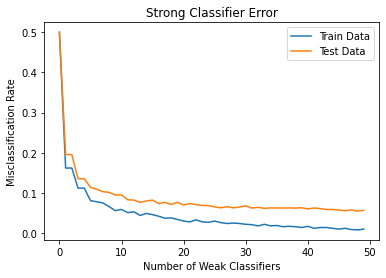

In [13]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.
train_errors = [calc_StrongClassifier_error(xTrain, yTrain, i) for i in range(nbrWeakClassifiers)]
test_errors = [calc_StrongClassifier_error(xTest, yTest, i) for i in range(nbrWeakClassifiers)]
plt.plot(range(nbrWeakClassifiers), train_errors)
plt.plot(range(nbrWeakClassifiers), test_errors)
plt.xlabel("Number of Weak Classifiers")
plt.ylabel("Misclassification Rate")
plt.legend(["Train Data", "Test Data"])
plt.title("Strong Classifier Error")
plt.show()

In [12]:
print(f"Test accuracy: {round(1 - test_errors[-1], 4) * 100}%")
print(f"Train accuracy: {round(1 - train_errors[-1], 4) * 100}%")

Test accuracy: 94.32000000000001%
Train accuracy: 99.0%


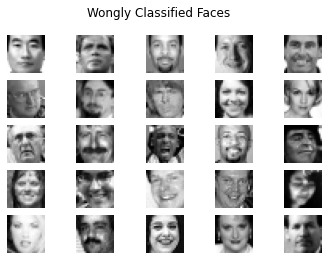

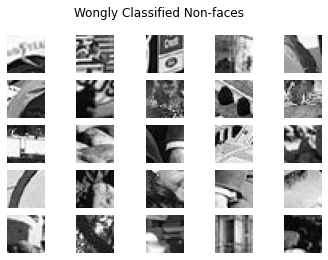

In [10]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.
indices = np.sign(np.sum([alpha[i] * WeakClassifier(final_Ts[i], final_Ps[i], xTest[i,:]) for i in range(nbrWeakClassifiers)], axis=0)) * yTest
indices = [yTest[i] if indices[i] == -1 else 0 for i in range(len(indices))]
faces_indices = [n for n,val in enumerate(indices) if val == 1]
nonfaces_indices = [n for n,val in enumerate(indices) if val == -1]
misclass_faces = testImages[:,:,faces_indices]
misclass_nonfaces = testImages[:,:,nonfaces_indices]

plt.figure()
for i in range(min(misclass_faces.shape[2], 25)):
    plt.subplot(5,5,i+1)
    plt.imshow(misclass_faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Wongly Classified Faces')

plt.figure()
for i in range(min(misclass_nonfaces.shape[2], 25)):
    plt.subplot(5,5,i+1)
    plt.imshow(misclass_nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Wongly Classified Non-faces')
plt.show()

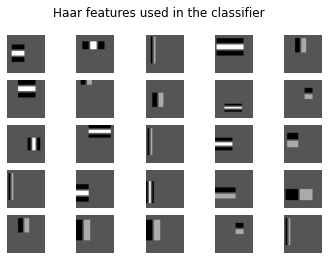

In [11]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.
plt.figure()
for k in range(min(nbrWeakClassifiers, 25)):
    current_haar_feature_index = final_haar_indices[k]
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,current_haar_feature_index], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features used in the classifier')
plt.show()